In [18]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [19]:
df = pd.read_csv('../../../data/preprocessed/feature_selection_by_model_final_data_30feature.csv')

X = df.drop(['price_per_m2'], axis=1)
y = df['price_per_m2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

In [21]:
param_grid = {
    'n_estimators': [300, 500, 800, 1000],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.8, 'log2', None],
    'bootstrap': [True, False],
    'max_samples': [0.6, 0.8, None],
    'ccp_alpha': [0.0, 0.01, 0.02]
}

In [22]:
rf_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


d:\anaconda\envs\env_v3.10\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda\envs\env_v3.10\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\anaconda\envs\env_v3.10\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\anaconda\envs\env_v3.10\lib\site-packages\sklearn\ensemble\_forest.py", line 431, in fit
    raise ValueError(
ValueError: `max_sample` cannot be set i

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0.0, 0.01, 0.02],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['sqrt', 0.8, 'log2',
                                                         None],
                                        'max_samples': [0.6, 0.8, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [300, 500, 800, 1000]},
                   random_state=42, scoring='r2', verbose=1)

In [23]:
tuned_rf = rf_search.best_estimator_
best_params = rf_search.best_params_
print(f"Best R² from RandomizedSearchCV: {rf_search.best_score_:.4f}")
print(f"Best parameters: {best_params}")

Best R² from RandomizedSearchCV: 0.9808
Best parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': None, 'max_features': None, 'max_depth': None, 'ccp_alpha': 0.01, 'bootstrap': True}


In [24]:
y_pred_test = tuned_rf.predict(X_test)

In [25]:
r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
mape = np.mean(np.abs((y_test - y_pred_test) / np.maximum(y_test, 1e-8))) * 100 

In [26]:
print(f"Test R²: {r2:.4f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test Avg Price: {y_test.mean():.2f}")

Test R²: 0.9852
Test MAE: 138.05
Test MAPE: 11.86%
Test Avg Price: 1936.11


In [27]:
# Evaluate on training set
y_train_pred = tuned_rf.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Evaluate on test set
y_test_pred = tuned_rf.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train R² Score: {r2_train:.3f}")
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Test R² Score: {r2_test:.3f}")
print(f"Test RMSE: {rmse_test:.2f}")

Train R² Score: 0.998
Train RMSE: 107.16
Test R² Score: 0.985
Test RMSE: 267.47


[learning_curve] Training set sizes: [ 593 1186 1779 2373 2966 3559 4153 4746 5339 5933]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.8min finished


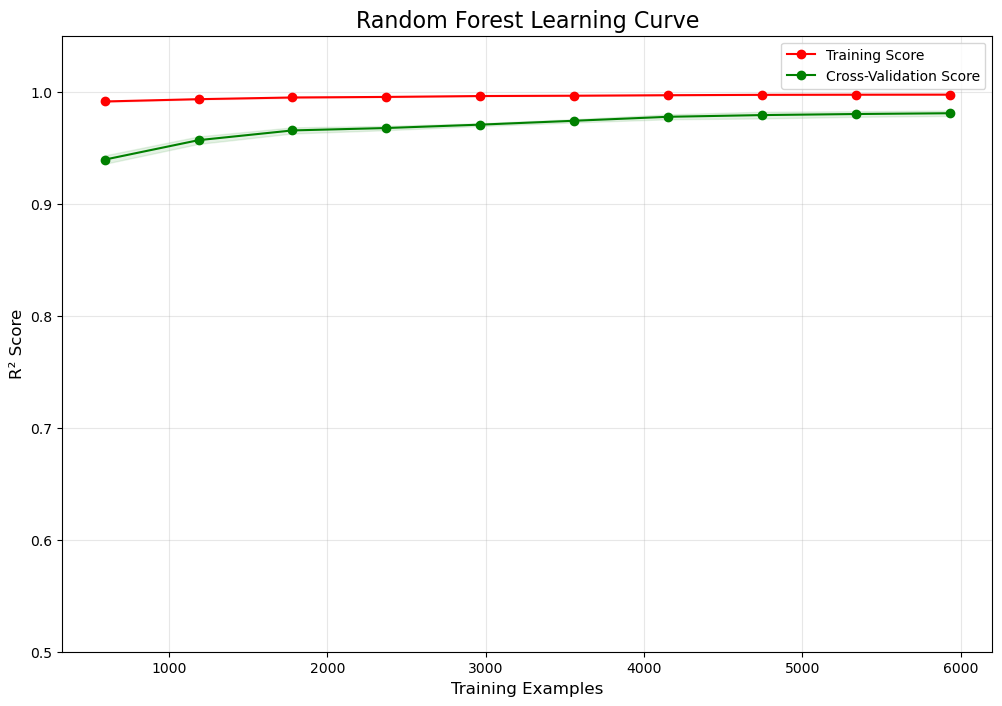

In [28]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    estimator=tuned_rf,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5,  
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.title("Random Forest Learning Curve", fontsize=16)
plt.xlabel("Training Examples", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.ylim(0.5, 1.05) 


plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.1,
    color="r"
)
plt.fill_between(
    train_sizes,
    val_mean - val_std,
    val_mean + val_std,
    alpha=0.1,
    color="g"
)

plt.plot(
    train_sizes,
    train_mean,
    'o-',
    color="r",
    label="Training Score"
)
plt.plot(
    train_sizes,
    val_mean,
    'o-',
    color="g",
    label="Cross-Validation Score"
)

plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.savefig("random_forest_learning_curve.png", dpi=300)
plt.show()

In [29]:

final_train_score = train_mean[-1]
final_val_score = val_mean[-1]
gap = final_train_score - final_val_score

In [30]:
print("\n" + "="*50)
print("Learning Curve Diagnostics:")
print(f"Final Training R²: {final_train_score:.4f}")
print(f"Final Validation R²: {final_val_score:.4f}")
print(f"Performance Gap: {gap:.4f}")



Learning Curve Diagnostics:
Final Training R²: 0.9974
Final Validation R²: 0.9808
Performance Gap: 0.0166


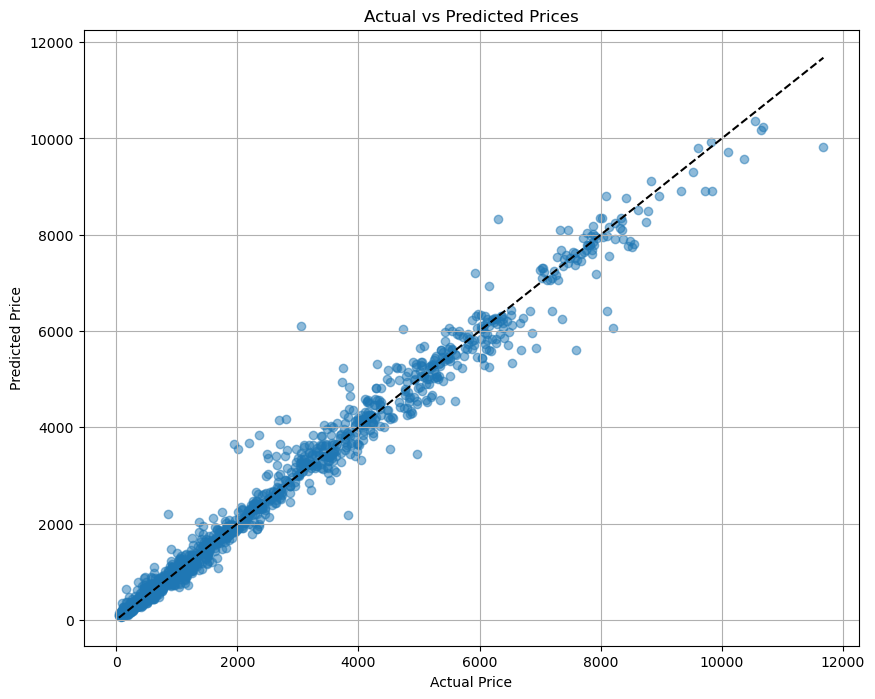

In [31]:
def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Prices')
    plt.grid(True)
    plt.savefig("rf_actual_vs_predicted.png")
    plt.show()

plot_actual_vs_predicted(y_test, y_pred_test)

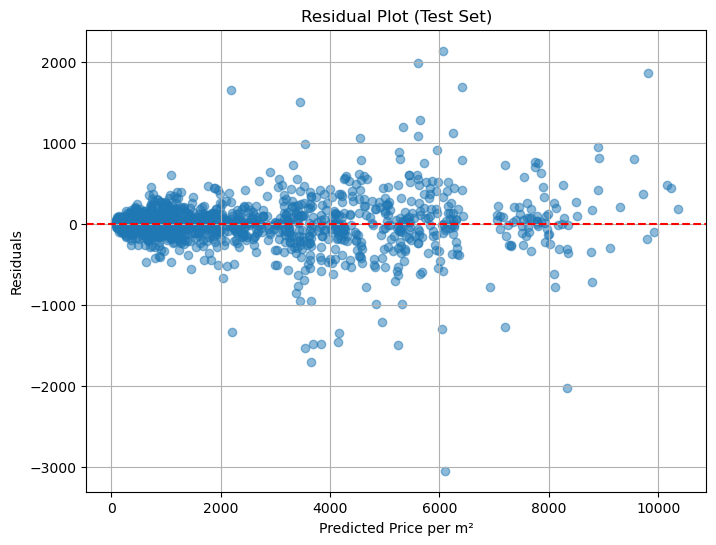

In [32]:
residuals = y_test - y_pred_test
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price per m²")
plt.ylabel("Residuals")
plt.title("Residual Plot (Test Set)")
plt.grid(True)
plt.show()